# Prediction de la survie d'un individu sur le Titanic

Ce tutoriel repose sur les données et le défi exemple de la communauté kaggle sur les données du titanic.

Il s'agit à partir de la liste des passagers du titanic et de leur survie ou non de prédire la chance de survie d'un individu en fonction de son nom, age, sexe, situation familiale, économique...

Ce notebook est inspiré par https://www.kaggle.com/mukultiwari/titanic-top-14-with-random-forest


In [67]:
import pandas as pd ; import numpy as np
import matplotlib.pyplot as plt ; import seaborn as sns
import multiprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import time
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')

# Données

On va utiliser la librairie pandas pour lire les données, on y a déposé le jeu de donnée disponible sur kaggle :
* le train.csv contient les données d'apprentissages, c'est à dire les variables décrivants des individus et s'ils ont survécus ou non.
* le test.csv contient uniquement la description d'individu dont il faut prédire leur chance de survie. 

---

In [68]:
import os

TrainingData = pd.read_csv('train.csv')
TestData = pd.read_csv('test.csv')

In [69]:
TrainingData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [70]:
TrainingData.info()
TestData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

On a :
* 7 variables numériques : **PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare**
    * dont **PassengerId** qui est l'identifiant du passager dans le dataset
    * dont **Survived** qui est la variable à prédire la variable "cible"
    * dont PClass qui est une indication de la strate socio économique
    * dont  SibSp et Parch qui permettent de déterminer la situation familiale(epoux, mère, fille...)
    * Fare qui est un prix ou quelque chose comme ca, traitons la sans la comprendre c'est pas la première et dernière fois que ca arrivera.
* 5 variables non numériques : **Name, Sex, Ticket** un identifiant de ticket, **Cabin** un identifiant de cabin, **Embarked** le port d'embarquation C = Cherbourg, Q = Queenstown, S = Southampton)

Recherchons s'il y a des valeurs manquantes dans ces 2 dataset

In [71]:
TrainingData.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [72]:
TestData.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Comme généralement en machine learning, il va falloir traiter ces valeurs manquantes en imputant des valeurs :
* dans le train dataset ( Age 177 manquants, Cabin 687 manquants, Embarked 2 manquants)
* dans le test dataset ( Age 86 manquants, Cabin 327 manquants, Fare 1 manquant)

---

# Un peu d'exploration et de feature engineering

Avant d'entrainer un modèle, il y a généralement une phase exploratoire du dataset que nous allons réduire ici au minimum.
Il y a aussi selon le contexte du feature engineering qui est probablement l'une des composantes les plus compliquées du machine learning, il s'agit selon le contexte et le problème de créer des variables qui ont un sens pour contribuer à résoudre notre problématique.

Ici, on peut en faire un exemple naturellement sur le nom de l'invidu et instinctivement en extrayant le titre du nom des individus, mais cela peut etre beaucoup moins naturel selon les problèmes voire même complètement un état de l'art si on prend l'exemple de la modélisation des images pour le machine learning ou il s'agit, par exemple, de proposer des valeurs pondérées par sous division de partie d'image.

---

# Passenger Id

Variable identifiant : on la stocke pour le dataset de test mais on la supprime du dataset l'identifiant n'ayant un sens que pour nous retrouver l'indvidu. Kaggle proposant d'uploader notre prédiction si l'on souhaite pour donner le score de notre algorithme.

In [73]:
passengerId = TestData['PassengerId']
TrainingData.drop(labels='PassengerId', axis=1, inplace=True)
TestData.drop(labels='PassengerId', axis=1, inplace=True)

In [74]:
TrainingData.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# variable : Pclass

Une variable catégorique qui donne une idée de la classe socio-économique de la personne dont on donne un exemple avec seaborn pour visualiser la contribution https://seaborn.pydata.org/

Clairement chaque classe n'avait pas la meme chance de survie, n'est ce pas Jack?

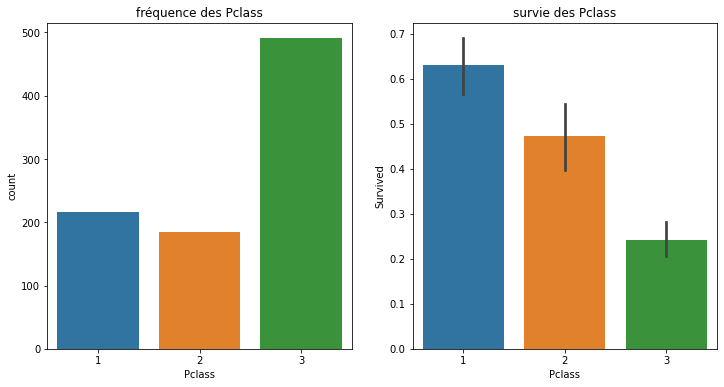

In [75]:
fig, axes=plt.subplots(1,2, figsize=(12, 6)) #layout matplotlib 1 ligne 2 colonnes taile 16*8
fig1_pclass=sns.countplot(data=TrainingData, x ="Pclass",    ax=axes[0]).set_title("fréquence des Pclass")
fig2_pclass=sns.barplot(data=TrainingData, x= "Pclass",y= "Survived", ax=axes[1]).set_title("survie des Pclass")

# Name

Nous allons essayer d'extraire du nom le titre qui peut etre présent dans le nom :
* le titre s'il y e en a du type Mr, Miss, Mrs... identifié comme le 1er mot après la **,**.

Exemple : Heikkinen, **Miss.** Laina	

In [76]:
#affichage des valeurs distinctes obtenues pour le 1er mot après la , dans les 2 dataset
print(TrainingData['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0]).unique())
print(TestData['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0]).unique())

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Ms.' 'Col.' 'Rev.' 'Dr.' 'Dona.']


In [77]:
# Extraction et ajout de la variable titre
TrainingData['Title'] = TrainingData['Name'].apply( lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
TestData['Title'] = TestData['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
# Suppression de la variable Titre
TrainingData.drop(labels='Name', axis=1, inplace=True)
TestData.drop(labels='Name', axis=1, inplace=True)
#On note que Dona est présent dans le jeu de test à prédire mais dans les variables d'apprentissage on règle ca a la mano
TestData['Title'] = TestData['Title'].replace('Dona.', 'Mrs.')

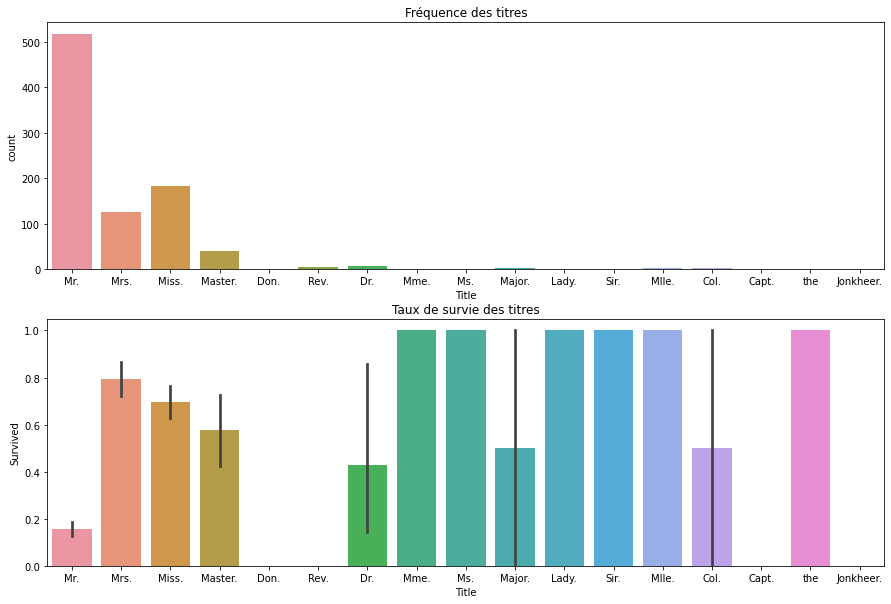

In [78]:
fx, axes = plt.subplots(2, 1, figsize=(15, 10))
fig1_title = sns.countplot(data=TrainingData, x='Title', ax=axes[0]).set_title("Fréquence des titres")
fig2_title = sns.barplot(data=TrainingData, x='Title',y='Survived', ax=axes[1]).set_title("Taux de survie des titres")

L'échelle n'as pas exceptionnelle, mais on voit bien que certains titre comme Mrs,Miss,Master, Lady,Sir était préférable.

Sinon tout le monde a vu le film et sait bien que le capitaine n'a pas survécu..

# Age

il nous faut traiter les valeurs nulls, il y a x facons de les traiter voici pour l'exemple un affichage de la distribution, on pourrait chercher tirer au hasard dans une distribution proche, chercher s'il y a des écarts d'age par exemple à partir du titre Miss pouvant surement etre plus jeune que Lady...

On va pas se faire suer pour notre part on va mettre la moyenne de l'age sur le bateau quand on ne la connait pas.

/home/coder/local/bin/conda/envs/basesspcloud/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, "distribution de l'age")

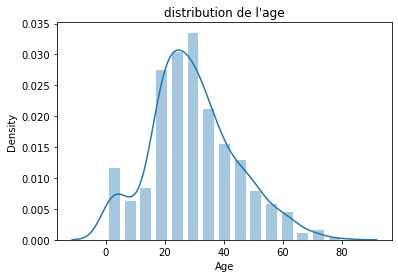

In [79]:
sns.distplot(a= TrainingData['Age'].dropna(axis = 0),bins = 15,hist_kws={'rwidth'     :0.7}).set_title("distribution de l'age")

In [80]:
meanAge=round(TrainingData['Age'].mean())
TrainingData['Age'] = TrainingData['Age'].fillna(meanAge)
TestData['Age'] = TrainingData['Age'].fillna(meanAge)

# Ticket

On pourrait regarder le contenu ou se renseigner sur les valeur de l'époque s'ils avaient une signification.

N'étant pas historien, on va mettre betement la longueur de la chaine de caractère comme variable, au pire si elle ne contribue pas on l'excluera ou le modèle l'excluera d'elle même.

In [81]:
# Making a new feature ticket length

TrainingData['Ticket_Len'] = TrainingData['Ticket'].apply(lambda x: len(x))
TestData['Ticket_Len'] = TestData['Ticket'].apply(lambda x: len(x))
TrainingData.drop(labels='Ticket', axis=1, inplace=True)
TestData.drop(labels='Ticket', axis=1, inplace=True)

# Fare

On s'y connait pas plus sur fare mais on doit la traiter car le dataset de test a une valeur null même sort que l'age on lui met une moyenne

In [82]:
TestData['Fare']=TestData['Fare'].fillna(TestData['Fare'].mean())

# Cabin

Le nombre de valeur null étant importante on va ajouter la variable hasCabin 1 ou 0 pour ne retenir que si la personne avait une cabine ou non, la encore en se renseignant peut etre que la numérotation des cabines avaient un sens plus précis.

In [83]:
# Making a new feature hasCabin which is 1 if cabin is available else 0
TrainingData['hasCabin'] = TrainingData.Cabin.notnull().astype(int)
TestData['hasCabin'] = TestData.Cabin.notnull().astype(int)

In [84]:
TrainingData.drop(labels='Cabin', axis=1, inplace=True)
TestData.drop(labels='Cabin', axis=1, inplace=True)

In [85]:
TrainingData.columns, TestData.columns

(Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked', 'Title', 'Ticket_Len', 'hasCabin'],
       dtype='object'),
 Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
        'Ticket_Len', 'hasCabin'],
       dtype='object'))

# Embarked

il a 2 null value dans Embarked qu'on ajoute à la valeur la plus fréquente S

In [86]:
TrainingData['Embarked'] = TrainingData['Embarked'].fillna('S')
TestData['Embarked'] = TestData['Embarked'].fillna('S')

In [87]:
#A ce stade on est "bon" sur le contenu des variables, il n'y a plus de valeurs null dans aucun des dataset
print(    TrainingData.isnull().sum())
print(TestData.isnull().sum()   )

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Ticket_Len    0
hasCabin      0
dtype: int64
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
Ticket_Len    0
hasCabin      0
dtype: int64


# Encoder les données imputées ou transformées.

In [88]:
# Voila nos données d'apprentissage
TrainingData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_Len,hasCabin
0,0,3,male,22.0,1,0,7.2500,S,Mr.,9,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs.,8,1
2,1,3,female,26.0,0,0,7.9250,S,Miss.,16,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs.,6,1
4,0,3,male,35.0,0,0,8.0500,S,Mr.,6,0


In [89]:
label_encoder_sex = LabelEncoder()
label_encoder_title = LabelEncoder()
label_encoder_embarked = LabelEncoder()
TrainingData['Sex'] = label_encoder_sex.fit_transform(TrainingData['Sex'].values)
TrainingData['Title'] = label_encoder_title.fit_transform(TrainingData['Sex'].values)
TrainingData['Embarked'] = label_encoder_embarked.fit_transform(TrainingData['Sex'].values)

In [90]:
TrainingData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_Len,hasCabin
0,0,3,1,22.0,1,0,7.2500,1,1,9,0
1,1,1,0,38.0,1,0,71.2833,0,0,8,1
2,1,3,0,26.0,0,0,7.9250,0,0,16,0
3,1,1,0,35.0,1,0,53.1000,0,0,6,1
4,0,3,1,35.0,0,0,8.0500,1,1,6,0


In [91]:
#On va maintenant passer du monde panda au monde numpy pour servir d'input à l'apprentissage pour cela on isole la variable cible
y = TrainingData.iloc[:, 0].values
#et le reste du dataset
X = TrainingData.iloc[:, 1:12].values

In [92]:
# Feature Scaling
scaler_x = MinMaxScaler((-1,1))
X = scaler_x.fit_transform(X)


In [93]:
# On splite notre dataset d'apprentisage pour faire de la validation croisée une partie pour apprendre une partie pour regarder le score
# On utilise pas le dataset de test de kaggle notre but est de se servir du dataset d'apprentissage et de s'assurer que le modèle le généralise bien pour l'appliquer ensuite sur le dataset de test du challenge
# Prenons arbitrairement 10% du dataset en test et 90% pour l'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Random Forest

Les forets aléatoires sont des algorithmes souvent performants en ce qui concerne les classifications.

L'idée est simple :
* On prend dans le dataset une partie des données et une partie des variables au hasard.
* On fait un arbre de décision sur ces données tirées aléatoirement, l'arbre de décision étant un algorithme permettant de déterminer la variable et sa valeur qui permet de séparer au mieux la population par rapport à notre variable cible le but étant de descendre aux feuilles les plus pures.

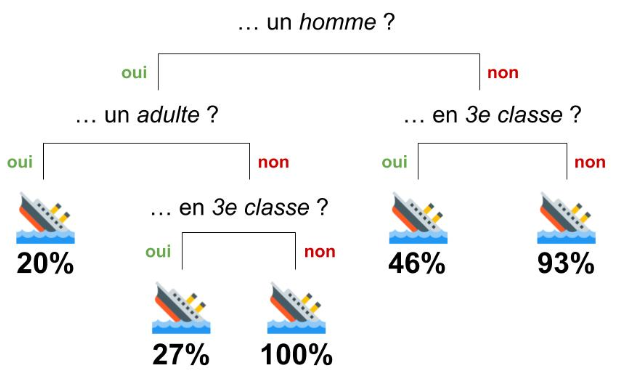

* Puis on recommence avec une autre sous partie des données et des variables, ce qui nous fait un second arbre...
* Du coup, plusieurs arbres aléatoires, ca nous fait une forêt...aléatoire.
* Un individu à prédire passera dans chacun des arbres et aura pour chaque arbre une prédiction, la prédiction finale étant la pondération de chacun de nos arbres.


In [94]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [95]:
#Ici demandons d'avoir 20 arbres
rdmf = RandomForestClassifier(n_estimators=20)
rdmf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [96]:
#calculons le score sur le dataset d'apprentissage et sur le dataset de test (10% du dataset d'apprentissage mis de côté)
# le score étant le nombre de bonne prédiction
rdmf_score = rdmf.score(X_test, y_test)
rdmf_score_tr = rdmf.score(X_train, y_train)
print("{} % de bonnes réponses sur les données de test pour validation (résultat qu'on attendrait si on soumettait notre prédiction sur le dataset de test.csv)".format(round(rdmf_score*100)))
from sklearn.metrics import confusion_matrix
print("matrice de confusion")
confusion_matrix(y_test, rdmf.predict(X_test))

87 % de bonnes réponses sur les données de test pour validation (résultat qu'on attendrait si on soumettait notre prédiction sur le dataset de test.csv)
matrice de confusion


array([[45,  5],
       [ 7, 33]])